## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from patsy import dmatrices
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.query("converted==1").user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
n1=df.query('(group=="control") & (landing_page=="new_page")').shape[0]
n2=df.query('(group=="treatment") & (landing_page=="old_page")').shape[0]
n1+n2

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.query('((group=="control")&(landing_page=="old_page"))or((group=="treatment")&(landing_page=="new_page"))')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset='user_id',keep="first",inplace=True)

c:\users\wanghe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
obs_old=df2.query('group=="control"').converted.mean()
obs_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
obs_new=df2.query('group=="treatment"').converted.mean()
obs_new

0.11880806551510564

In [17]:
obs_diff=obs_new-obs_old
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
p_received_new=df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]
p_received_new

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

***The 50% probability of an individual receiving new page indicated the size of control group and treatment group were the same, so we can compare the two probabilities of conversions of both groups. The result is that the control group seemed to have higher probability to convert than the treatment group. But the difference is too small, it seems there's no need to convert to the new page. And we can't say this difference is significant and conclude that the old treatment page leads to more conversions.***

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

            `H0:P𝑛𝑒𝑤 - P𝑜𝑙𝑑 <= 0
             H1:P𝑛𝑒𝑤 - P𝑜𝑙𝑑 > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new=df2.groupby('group').user_id.count()[1]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old=df2.groupby('group').user_id.count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted=df2.sample(n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=df2.sample(n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new_sam=new_page_converted.converted.mean()
p_old_sam=old_page_converted.converted.mean()
sample_diff=p_new_sam-p_old_sam
sample_diff

-0.0009105232604262187

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [ ]:
p_diffs=[]
for _ in range(10000):
    sample_new=df2.sample(n_new)
    sample_old=df2.sample(n_old)
    p_new=sample_new.converted.mean()
    p_old=sample_old.converted.mean()
    diff=p_new-p_old
    p_diffs.append(diff)
p_diffs=np.array(p_diffs)

In [27]:
p_diffs.mean()

-1.9547675740247501e-06

In [28]:
p_diffs.std()

0.00086461613470381084

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

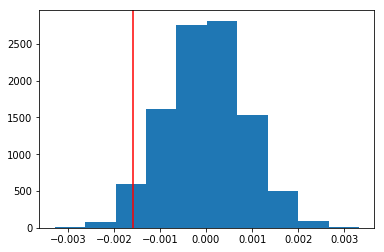

In [29]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff,color="red")

This is what I expected, a symmetric like normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_value=(p_diffs>obs_diff).mean()
p_value

0.96509999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

***It's called the P value. It means the probability of observing the statistic if the null hypothesis is true.In this test, p value is 0.9651,very close to 1, therefore, we are failed to reject the null hypothesis.
<br>The p value indicated that only about 0.0349 of the simulated difference can be explained by the alternative hypothesis.
<br>96.51% is a lot higher than the threshold of 5% type I error, meaning that the new group's conversion rate is not statistically significantly higher than the old group's conversion rate.***

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('(group=="control")&(converted==1)').shape[0]
convert_new = df2.query('(group=="treatment")&(converted==1)').shape[0]
# I have already calculated the n_old and n_new above.
print(n_old)
print(n_new)
print(convert_old)
print(convert_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


145274
145310
17489
17264


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
stat, pval = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],value=0,alternative="smaller")
print(stat, pval)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

***A Z-score is a numerical measurement used in statistics of a value's relationship to the mean of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.(Investopedia)
<br>
<br>The Z-score is 1.311, meaning there are a 1.311 od standard deviation between the element and the mean, smaller than a standard deviation of 2 contains(95%). So, the difference is not statistically significantly over 0. We failed to reject the null hypothesis.
<br>
<br>The p value, which is 0.9051, is a lot higher than the threshold of 5%. Still, we can't reject the null hypothesis.
<br>
<br>The results here gave the same conclusion as parts j and k.***

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

***Logistic Regression, because its dependent variable usually has two values.***

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2[['new','old']]=pd.get_dummies(df['landing_page'])
df2['intercept']=1
df2.drop(columns='old',inplace=True)
df2.rename(columns={"new":"ab_page"},inplace=True)
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
lm=sm. Logit(df2['converted'],df2[['intercept','ab_page']])
result=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        07:20:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

***The p-value associated with ab_page is 0.190.
<br>
<br>The null hypothesis of ab_page in logistic regression model is the coefficient of ab_page is equal to 0, meaning ab_page has no impact to the conversion. This is a two-tail test and has two directions, but in part II, the null hypothesis is one direction and it's a one_tail test.***

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***The conversion rate might be influenced by the change aversion or novelty effect. Some people might think it's exiciting to try new pages but some people might dislike the new version and prefer old pages. This usually happens at the begining of the test. I would like to extend the time.
<br>
<br>Since it's an e-commerce website. Whether a customer would convert might be affected by the price index. I would like to add a new factor that represent the price change, eg. discounts.
<br>
<br>I would like to add the duration of each customer stayed at the page.
<br>
<br>E-commerce industry usually has seasonal changes. I would like to add variables indicating the season.
<br>
<br>By adding more factors in the model, the R-square would become higher, but the more factors increase the probability of multicollinearity,meaning variables might be correlated with each other. Multicollinearity might flip the coefficients and make no sence in the real world.***

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
df_countries=pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df3=df2.merge(df_countries,on="user_id",how="left")
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [38]:
df3[['CA','UK','US']]=pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


***I chose US as the baseline.***

In [39]:
lm=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
result=lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 29 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        07:20:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [40]:
np.exp(-0.0149),np.exp(-0.0408),np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

***From the table we can say: 1.
<br>A UK customer is 1.01 times more likely than a US customer to convert when holding other factors constant.
<br>A CA customer is 0.96 times more likely than a US customer to convert when holding other factors constant.
<br>A new_page customer is 0.99 times more likely than an old_page customer to convert when holding other factors constant.
<br>But we can see the all the p values are higher than 5%, they are all not statistical significant.The new page is not significantly better than the old page.The country factor seems not significantly impact the conversion***

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

Add interactions of countries and ab_page.

In [41]:
df3['ab_page_UK']=df3['ab_page']*df3['UK']
df3['ab_page_CA']=df3['ab_page']*df3['CA']

In [42]:
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,ab_page_UK,ab_page_CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [43]:
lm=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK','ab_page_UK','ab_page_CA']])
result=lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Dec 2019   Pseudo R-squ.:               3.482e-05
Time:                        07:20:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

***We can see all p values are higher than 5%, they are not statistically significant. We can say the interactions between "ab_page" and "country" are not significantly impact the conversion***

In [44]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
y,X=dmatrices('converted~ab_page + CA + UK + ab_page_UK + ab_page_CA',df3,return_type="dataframe")
vif=pd.DataFrame()
vif['Factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['Features']=X.columns

In [46]:
vif

,Factor,Features
0,2.856817,Intercept
1,1.427098,ab_page
2,2.049235,CA
3,2.030763,UK
4,2.366531,ab_page_UK
5,2.103521,ab_page_CA


***All factors are lower than 10, no need to drop any factor. The multicollinearity can be ignored.***

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score
from sklearn.model_selection import train_test_split

In [48]:
y=df3['converted']
X=df3[['ab_page','CA','UK','ab_page_UK','ab_page_CA']]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
log_mod=LogisticRegression()
log_mod.fit(X_train,y_train)
y_pred=log_mod.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
confusion_matrix(y_test,y_pred)

0.879539134983
0.0
0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[63895,     0],
       [ 8751,     0]])

***Even though the accuracy score is high, the recall rate and precision rate are 0, too low, meaning the model is not well fit.***

***Summary: The country factor and the interactions of country and ab_page are not significantly impact the conversion. The model is not well fit, meaning there are other things need to be considered, such as adding more factors.***

In [49]:
#Get the exact day of each timestamp, name the factor "date".
import datetime as dt
df3['date']=pd.to_datetime(df3['timestamp']).dt.weekday
#Make the weekday is 1 and weekend is 0.
df3['weekday']=(df3['date']<5).astype(int)
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,ab_page_UK,ab_page_CA,date,weekday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0,5,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0,3,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,2,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,6,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0,5,0


In [139]:
lm=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK','ab_page_UK','ab_page_CA','weekday']])
result=lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Sun, 29 Dec 2019   Pseudo R-squ.:               3.483e-05
Time:                        06:40:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2845
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9861      0.013   -148.331      0.000      -2.012      -1.960
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
weekday       -0.0006      0.013     -0.045      0.964      -0.026       0.025
==============================================================================
"""

***All p values are still higher than 5%, not statistically significant. The p-value of weekday is 0.964, indicating the "weekday" factor has no significant impact on the conversion.***

In [50]:
y,X=dmatrices('converted~ab_page + CA + UK + weekday',df3,return_type="dataframe")
vif=pd.DataFrame()
vif['Factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['Features']=X.columns

In [51]:
vif

,Factor,Features
0,5.079196,Intercept
1,1.000009,ab_page
2,1.017760,CA
3,1.017769,UK
4,1.000012,weekday


***All VIF factors are lower than 10, so there are no needs to care about the multicollinearity.
<br>
<br>The model is still not well fit, it needs more modification, such as adding "duration" factor in the model.***

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0